In [3]:
# Block 0: imports and configuration
# Set file path, target name, random seed and artifact settings here.
import os
import json
import math
import time
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.compose import TransformedTargetRegressor

# Edit these values as needed for your environment
CSV_PATH = r"C:\Users\jarvi\.vscode\Python\TNSIF_AIML_DBIT\manufacturing_dataset_1000_samples.csv"
TARGET = "Parts_Per_Hour"
TEST_SIZE = 0.2
RANDOM_STATE = 42
SAVE_ARTIFACTS = True
ARTIFACTS_DIR = "artifacts"

# Underperformance thresholds (percentiles of training target)
UNDERPERF_PCT_BASELINE = 25.0
UNDERPERF_PCT_TUNED = 30.0


In [ ]:
# Block 1: helper functions and QuantileClipper transformer
# These helpers compute metrics and extract feature names after preprocessing.
def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {
        "RMSE": float(np.sqrt(mse)),
        "MSE": float(mse),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
        "MAPE": float(mape)
    }

def class_report(y_true_cls, y_pred_cls):
    return {
        "precision": float(precision_score(y_true_cls, y_pred_cls, zero_division=0)),
        "recall": float(recall_score(y_true_cls, y_pred_cls, zero_division=0)),
        "f1": float(f1_score(y_true_cls, y_pred_cls, zero_division=0)),
        "accuracy": float(accuracy_score(y_true_cls, y_pred_cls))
    }

def get_feature_names(pre: ColumnTransformer) -> List[str]:
    num_name_list = []
    cat_name_list = []
    for name, trans, cols in pre.transformers_:
        if name == "num":
            poly = trans.named_steps.get("poly", None)
            if poly is not None:
                try:
                    num_name_list = poly.get_feature_names_out(cols).tolist()
                except Exception:
                    num_name_list = list(cols)
            else:
                num_name_list = list(cols)
        if name == "cat":
            ohe = trans.named_steps.get("onehot", None)
            if ohe is not None:
                try:
                    cat_name_list = ohe.get_feature_names_out(cols).tolist()
                except Exception:
                    cat_name_list = list(cols)
            else:
                cat_name_list = list(cols)
    return num_name_list + cat_name_list

class QuantileClipper(BaseEstimator, TransformerMixin):
    # Simple transformer to cap numeric values at lower/upper quantiles learned from train
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_: Optional[np.ndarray] = None
        self.upper_bounds_: Optional[np.ndarray] = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.lower_bounds_ = np.nanquantile(X, self.lower, axis=0)
        self.upper_bounds_ = np.nanquantile(X, self.upper, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)


In [5]:
# Block 2: load dataset and quick checks, extract time features if present
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

print("Dataset shape:", df.shape)
print("\nTop missing columns:")
print(df.isna().sum().sort_values(ascending=False).head(10))

# If there's a timestamp-like column, extract hour/day/month and drop the raw timestamp
time_like = [c for c in df.columns if c.lower() in ("timestamp", "datetime", "date_time", "time")]
if time_like:
    ts = time_like[0]
    df[ts] = pd.to_datetime(df[ts], errors="coerce")
    df["Hour"] = df[ts].dt.hour
    df["Day"] = df[ts].dt.day
    df["Month"] = df[ts].dt.month
    df["Year"] = df[ts].dt.year
    df["DayOfWeek_num"] = df[ts].dt.dayofweek
    df.drop(columns=[ts], inplace=True)
    print("Extracted Hour/Day/Month/Year/DayOfWeek_num from timestamp.")


Dataset shape: (1000, 19)

Top missing columns:
Operator_Experience      20
Material_Viscosity       20
Ambient_Temperature      20
Injection_Pressure        0
Injection_Temperature     0
Timestamp                 0
Cooling_Time              0
Cycle_Time                0
Machine_Age               0
Maintenance_Hours         0
dtype: int64
Extracted Hour/Day/Month/Year/DayOfWeek_num from timestamp.


In [6]:
# Block 3: add domain-informed interaction/ratio features
# These are straightforward: they make physical sense and often help a linear model.
if {"Injection_Temperature", "Injection_Pressure"}.issubset(df.columns):
    df["Temp_Pressure_Product"] = df["Injection_Temperature"] * df["Injection_Pressure"]
if {"Cycle_Time", "Cooling_Time"}.issubset(df.columns):
    df["Cycle_Cooling_Ratio"] = df["Cycle_Time"] / (df["Cooling_Time"] + 1e-5)

# show new columns if added
new_cols = [c for c in ("Temp_Pressure_Product", "Cycle_Cooling_Ratio") if c in df.columns]
print("Engineered features added:", new_cols)


Engineered features added: ['Temp_Pressure_Product', 'Cycle_Cooling_Ratio']


In [7]:
# Block 4: define target and split the dataset
if TARGET not in df.columns:
    raise ValueError(f"Target {TARGET} not found in dataset columns.")

y = df[TARGET].astype(float).copy()
X = df.drop(columns=[TARGET]).copy()

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 24) Test shape: (200, 24)


In [8]:
# Block 5: identify categorical and numeric columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object" or str(X_train[c].dtype).startswith("category")]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns (first 10):", num_cols[:10])


Categorical columns: ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
Numeric columns (first 10): ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Temperature_Pressure_Ratio']


In [9]:
# Block 6: build preprocessing pipelines for numeric and categorical data
# Numeric steps: impute median -> quantile clip -> polynomial features (degree 2) -> robust scale
# Categorical steps: impute mode -> one-hot encode

numeric_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", QuantileClipper(lower=0.01, upper=0.99)),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", RobustScaler())
])

categorical_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_prep, num_cols),
        ("cat", categorical_prep, cat_cols)
    ],
    remainder="drop"
)

# Fit preprocess on training set so subsequent blocks can use get_feature_names and transform quickly
preprocess.fit(X_train)
print("Preprocessing fitted on training set.")


Preprocessing fitted on training set.


In [10]:
# Block 7: define the model pipeline. Ridge is our linear model (regularized).
# We wrap the pipeline in TransformedTargetRegressor to stabilize target distribution using Yeo-Johnson.
ridge = Ridge(random_state=RANDOM_STATE)

model = TransformedTargetRegressor(
    regressor=Pipeline(steps=[("preprocess", preprocess), ("model", ridge)]),
    transformer=PowerTransformer(method="yeo-johnson", standardize=True)
)

print("Model pipeline is ready. It includes preprocessing and a Yeo-Johnson target transformer.")


Model pipeline is ready. It includes preprocessing and a Yeo-Johnson target transformer.


In [11]:
# Block 8: grid search to find best alpha for Ridge
param_grid = {
    "regressor__model__alpha": [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    verbose=0
)


print("Starting GridSearchCV. This may take a bit of time.")
start = time.time()
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
end = time.time()
print(f"Grid search finished in {end - start:.1f} seconds.")

best_model = gs.best_estimator_
best_params = gs.best_params_
best_cv_mse = -gs.best_score_
print(f"Best parameters: {best_params} | Cross-validated MSE: {best_cv_mse:.4f}")


Starting GridSearchCV. This may take a bit of time.
Grid search finished in 10.7 seconds.
Best parameters: {'regressor__model__alpha': 3} | Cross-validated MSE: 10.3770


In [12]:
# Block 9: predict on test and compute regression metrics
y_pred = best_model.predict(X_test)
metrics_test = regression_report(y_test, y_pred)
print("Test set regression metrics:")
print(json.dumps(metrics_test, indent=2))


Test set regression metrics:
{
  "RMSE": 3.1019163925039233,
  "MSE": 9.621885306084554,
  "MAE": 2.307069917462557,
  "R2": 0.9262650380881535,
  "MAPE": 9.279891903468048
}


In [13]:
# Block 10: create binary underperformance labels (business use)
# We define thresholds from training target percentiles to avoid data leakage.

thr_base = float(np.percentile(y_train, UNDERPERF_PCT_BASELINE))
y_test_cls_true_base = (y_test < thr_base).astype(int)
y_test_cls_pred_base = (y_pred < thr_base).astype(int)
cls_base = class_report(y_test_cls_true_base, y_test_cls_pred_base)

thr_tuned = float(np.percentile(y_train, UNDERPERF_PCT_TUNED))
y_test_cls_true_tuned = (y_test < thr_tuned).astype(int)
y_test_cls_pred_tuned = (y_pred < thr_tuned).astype(int)
cls_tuned = class_report(y_test_cls_true_tuned, y_test_cls_pred_tuned)

print(f"Underperformance detection at {UNDERPERF_PCT_BASELINE:.0f}th percentile (threshold {thr_base:.3f}):")
print(json.dumps(cls_base, indent=2))
print(f"Underperformance detection at {UNDERPERF_PCT_TUNED:.0f}th percentile (threshold {thr_tuned:.3f}):")
print(json.dumps(cls_tuned, indent=2))


Underperformance detection at 25th percentile (threshold 17.700):
{
  "precision": 0.9705882352941176,
  "recall": 0.6226415094339622,
  "f1": 0.7586206896551724,
  "accuracy": 0.895
}
Underperformance detection at 30th percentile (threshold 20.400):
{
  "precision": 0.9491525423728814,
  "recall": 0.7887323943661971,
  "f1": 0.8615384615384616,
  "accuracy": 0.91
}


In [14]:
# Block 11: extract feature names and coefficients to inspect which features matter most
inner_pipe = best_model.regressor_
coef = inner_pipe.named_steps["model"].coef_
feat_names = get_feature_names(inner_pipe.named_steps["preprocess"])

# Handle mismatch safety: if shapes mismatch, create generic names
if len(coef) != len(feat_names):
    feat_names = [f"f_{i}" for i in range(len(coef))]

coef_df = pd.DataFrame({"feature": feat_names, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

print("Top 15 most influential features by absolute coefficient value:")
print(coef_df.head(15).to_string(index=False))


Top 15 most influential features by absolute coefficient value:
                             feature  coefficient  abs_coef
                  Total_Cycle_Time^2    -0.395258  0.395258
         Cycle_Time Total_Cycle_Time    -0.386911  0.386911
                        Cycle_Time^2    -0.356164  0.356164
Total_Cycle_Time Cycle_Cooling_Ratio    -0.317085  0.317085
      Cycle_Time Cycle_Cooling_Ratio    -0.274580  0.274580
                         Shift_Night    -0.178060  0.178060
                 Machine_Type_Type_A     0.169179  0.169179
               Cycle_Cooling_Ratio^2    -0.155416  0.155416
                           Shift_Day     0.149661  0.149661
                 Machine_Type_Type_C    -0.141475  0.141475
    Material_Viscosity DayOfWeek_num    -0.124873  0.124873
              Material_Grade_Economy    -0.121789  0.121789
              Material_Grade_Premium     0.119667  0.119667
                Material_Viscosity^2     0.118382  0.118382
                 Month DayOfWeek_num

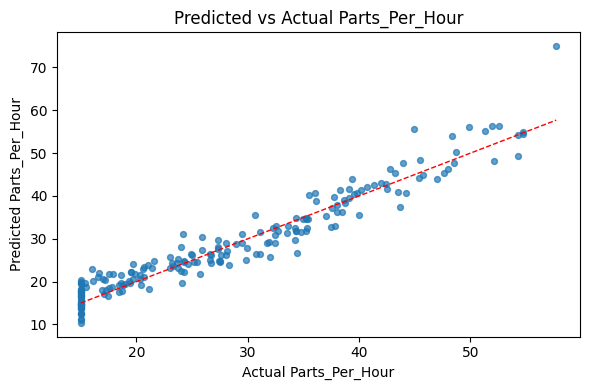

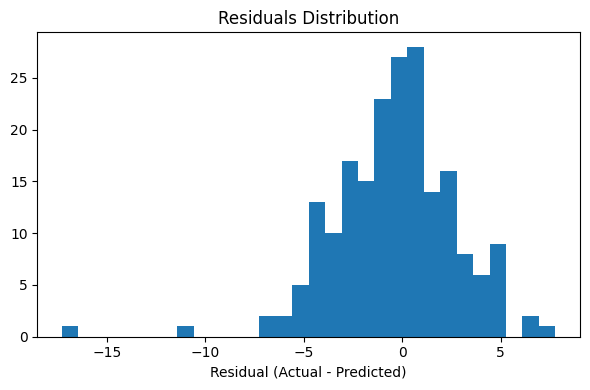

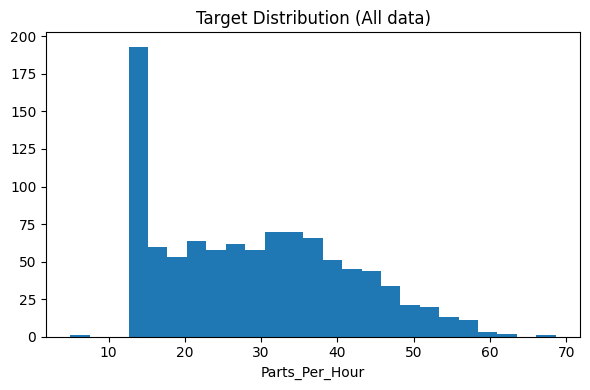

In [15]:
# Block 12: plotting for diagnostics
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, s=18, alpha=0.7)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.title("Predicted vs Actual Parts_Per_Hour")
plt.xlabel("Actual Parts_Per_Hour")
plt.ylabel("Predicted Parts_Per_Hour")
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y, bins=25)
plt.title("Target Distribution (All data)")
plt.xlabel("Parts_Per_Hour")
plt.tight_layout()
plt.show()


In [16]:
# Block 13: save model artifact and final notes
if SAVE_ARTIFACTS:
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    model_path = os.path.join(ARTIFACTS_DIR, "ridge_linear_regression_model.joblib")
    joblib.dump(best_model, model_path)
    print("Saved trained model to:", model_path)

print("\nDone. The pipeline used Ridge (a linear model) with preprocessing, polynomial features,")
print("a Yeo-Johnson target transform, quantile clipping and grid-searched alpha. This keeps us")
print("within the 'linear regression' family while improving robustness and predictive performance.")


Saved trained model to: artifacts\ridge_linear_regression_model.joblib

Done. The pipeline used Ridge (a linear model) with preprocessing, polynomial features,
a Yeo-Johnson target transform, quantile clipping and grid-searched alpha. This keeps us
within the 'linear regression' family while improving robustness and predictive performance.


In [17]:
# ---------------------------
# Block 9: Evaluate, save, and verify best_model (place immediately after your GridSearch block)
# ---------------------------
import joblib
import json
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Evaluate on test set
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# MAPE: avoid divide-by-zero
mape = 100.0 * np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-6, y_test)))

print("Test MSE: {:.4f}".format(mse))
print("Test RMSE: {:.4f}".format(rmse))
print("Test MAE: {:.4f}".format(mae))
print("Test R2: {:.4f}".format(r2))
print("Test MAPE (%): {:.2f}".format(mape))

# 2) Save model pipeline (joblib recommended)
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
model_path = os.path.join(ARTIFACT_DIR, "ridge_pipeline_best.joblib")
joblib.dump(best_model, model_path, compress=3)
print(f"✅ Saved model pipeline to: {model_path}")

# 3) Save minimal metadata (metrics + features)
metadata = {
    "model_file": os.path.basename(model_path),
    "timestamp": __import__("datetime").datetime.now().isoformat(),
    "mse": float(mse),
    "rmse": float(rmse),
    "mae": float(mae),
    "r2": float(r2),
    "mape_percent": float(mape),
    "best_params": best_params
}
# try to include feature list if X exists
try:
    metadata["features"] = list(X.columns)
except Exception:
    metadata["features"] = None

meta_path = os.path.join(ARTIFACT_DIR, "ridge_pipeline_best_metadata.json")
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata to: {meta_path}")

# 4) Verify: load and predict a sample
loaded = joblib.load(model_path)
print("✅ Model reloaded OK.")

# pick a sample row from X_test (preserve DataFrame type if used earlier)
sample = X_test.iloc[:1] if hasattr(X_test, "iloc") else X_test[:1]
try:
    sample_pred = loaded.predict(sample)
    print("Sample prediction:", sample_pred.tolist())
except Exception as e:
    print("⚠️ Model loaded but prediction failed:", e)
    raise

# Done
print("Model evaluation, save and verification complete.")


Test MSE: 9.6219
Test RMSE: 3.1019
Test MAE: 2.3071
Test R2: 0.9263
Test MAPE (%): 9.28
✅ Saved model pipeline to: artifacts\ridge_pipeline_best.joblib
✅ Saved metadata to: artifacts\ridge_pipeline_best_metadata.json
✅ Model reloaded OK.
Sample prediction: [19.74182963203151]
Model evaluation, save and verification complete.


In [18]:
print(best_model)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('clipper',
                                                                                                        QuantileClipper()),
                                                                                                       ('poly',
                                                                                                        PolynomialFeatures(include_bias=False)),
                                                                                        

In [19]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, "artifacts/final_ridge_pipeline.joblib", compress=3)
print("✅ Full pipeline saved successfully at artifacts/final_ridge_pipeline.joblib")

✅ Full pipeline saved successfully at artifacts/final_ridge_pipeline.joblib


In [21]:
joblib.dump(best_model, "artifacts/final_ridge_pipeline.joblib", compress=3)


['artifacts/final_ridge_pipeline.joblib']

In [22]:
import json, datetime, sklearn, platform
metadata = {
    "model_file": "final_ridge_pipeline.joblib",
    "timestamp": datetime.datetime.now().isoformat(),
    "model_type": "TransformedTargetRegressor(Ridge)",
    "alpha": 3,
    "r2": float(r2),
    "rmse": float(rmse),
    "mae": float(mae),
    "mape": float(mape),
    "mse": float(mse),
    "python_version": platform.python_version(),
    "sklearn_version": sklearn.__version__
}
with open("artifacts/model_metadata.json","w") as f:
    json.dump(metadata,f,indent=2)
print("✅ Metadata saved.")


✅ Metadata saved.


In [23]:
loaded_model = joblib.load("artifacts/final_ridge_pipeline.joblib")
sample = X_test.iloc[:1]
print("Prediction OK:", loaded_model.predict(sample))


Prediction OK: [19.74182963]
